In [23]:
import pandas as pd
from textblob import TextBlob
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sentiment_labels = pd.read_csv("sentiment_labels.txt", delimiter="|", quoting=3)
sentiment_labels.head()

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [3]:
dictionary = pd.read_csv("dictionary.txt", delimiter="|", quoting=3, header=None)
dictionary.columns = ['phrase', 'phrase ids']
dictionary.head()

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [5]:
sentences = pd.read_csv("datasetSentences.txt", delimiter="\t", quoting=3)
sentences.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [6]:
dataset = pd.merge(dictionary, sentiment_labels, how='left', on=['phrase ids'])
dataset.head()

,phrase,phrase ids,sentiment values
0,!,0,0.50000
1,! ',22935,0.52778
2,! '',18235,0.50000
3,! Alas,179257,0.44444
4,! Brilliant,22936,0.86111


In [7]:
classes = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
Class = []
for i in range(0, 239232):
  val = dataset['sentiment values'][i]
  if val >= 0 and val <= 0.2:
    Class.append(classes[0])
  if val > 0.2 and val <= 0.4:
    Class.append(classes[1])
  if val > 0.4 and val <= 0.6:
    Class.append(classes[2])
  if val > 0.6 and val <= 0.8:
    Class.append(classes[3])
  if val > 0.8 and val <= 1:
    Class.append(classes[4])

In [8]:
dataset['class'] = Class
dataset.head()

,phrase,phrase ids,sentiment values,class
0,!,0,0.50000,neutral
1,! ',22935,0.52778,neutral
2,! '',18235,0.50000,neutral
3,! Alas,179257,0.44444,neutral
4,! Brilliant,22936,0.86111,very positive


Using TextBlob to calculate sentiment polarity which lies in the range of [-1,1] where 1 means positive sentiment and -1 means a negative sentiment.
Create new feature for the length of the phrase/sentence.
Create new feature for the word count of the phrase/sentence.

In [9]:
sentences['polarity'] = sentences['sentence'].map(lambda text: TextBlob(text).sentiment.polarity)
sentences['sentence_len'] = sentences['sentence'].astype(str).apply(len)
sentences['word_count'] = sentences['sentence'].apply(lambda x: len(str(x).split()))
sentences.head()

,sentence_index,sentence,polarity,sentence_len,word_count
0,1,The Rock is destined to be the 21st Century 's...,0.212121,181,36
1,2,The gorgeously elaborate continuation of `` Th...,0.244444,227,37
2,3,Effective but too-tepid biopic,0.600000,30,4
3,4,If you sometimes like to go to the movies to h...,0.500000,89,21
4,5,"Emerges as something rare , an issue movie tha...",0.450000,113,23


In [10]:
dataset['polarity'] = dataset['phrase'].map(lambda text: TextBlob(text).sentiment.polarity)
dataset['phrase_len'] = dataset['phrase'].astype(str).apply(len)
dataset['word_count'] = dataset['phrase'].apply(lambda x: len(str(x).split()))
dataset.head()

,phrase,phrase ids,sentiment values,class,polarity,phrase_len,word_count
0,!,0,0.50000,neutral,0.0,1,1
1,! ',22935,0.52778,neutral,0.0,3,2
2,! '',18235,0.50000,neutral,0.0,4,2
3,! Alas,179257,0.44444,neutral,-0.4,6,2
4,! Brilliant,22936,0.86111,very positive,0.9,11,2


In [11]:
print('5 random phrases with the highest positive sentiment values: \n')
cl = dataset.loc[dataset['sentiment values'] == 1, ['phrase']].sample(5).values
for c in cl:
    print(c[0])

5 random phrases with the highest positive sentiment values: 

ms . seigner and mr . serrault bring fresh , unforced naturalism to their characters
the perfect movie
this is one of the year 's best films
The storylines are woven together skilfully , the magnificent swooping aerial shots are breathtaking , and the overall experience is awesome .
one of the finest films of the year .


In [12]:
print('5 random sentences with the highest positive polarity: \n')
cl = sentences.loc[sentences['polarity'] == 1, ['sentence']].sample(5).values
for c in cl:
    print(c[0])

5 random sentences with the highest positive polarity: 

The humor and humanity of Monsoon Wedding are in perfect balance .
A wonderful character-based comedy .
Another Best of the Year selection .
Ranks among Willams ' best screen work .
It 's Quaid who anchors the film with his effortless performance and that trademark grin of his -- so perfect for a ballplayer .


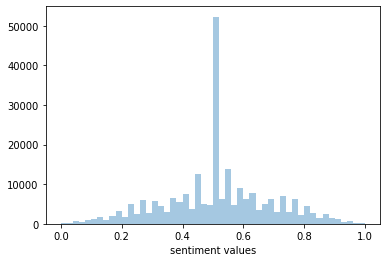

In [19]:
sns.distplot(dataset['sentiment values'], kde=False) 

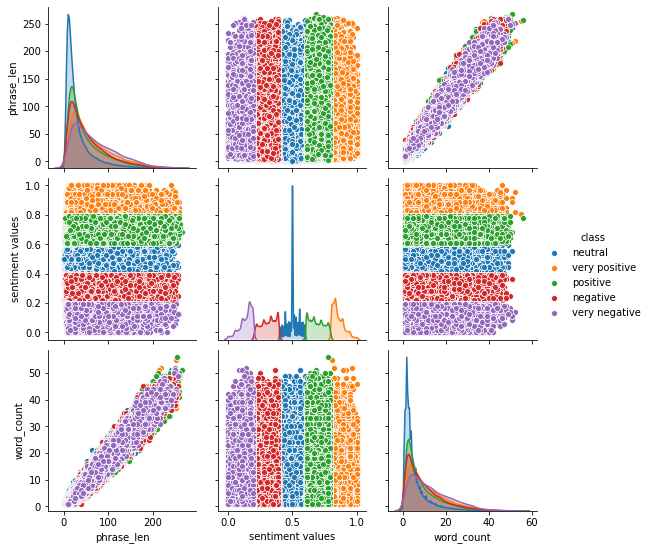

In [17]:
sns.pairplot(dataset[['phrase_len', 'sentiment values', 'word_count', 'class']], hue='class')

Vast majority of the sentiment value scores are between 0.4 and 0.6, means most of them are neutral.
The majority of the phrase length is in between 0 to 50.
The word count also seems to be following the same trajectory, obviously.

The distribution review text lengths

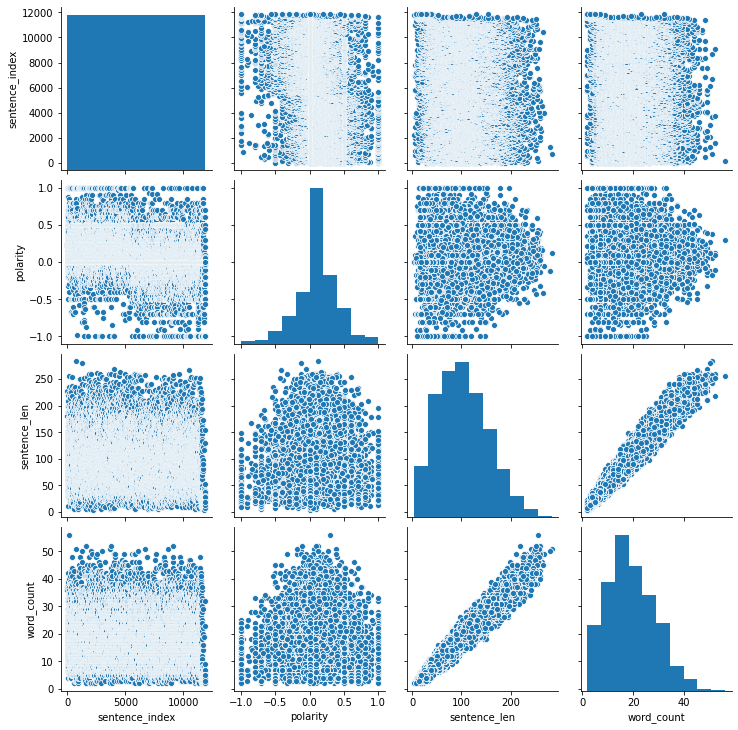

In [ ]:
sns.pairplot(sentences)

The distribution of top unigrams before removing stop words

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

the 84111
and 52381
of 52378
to 37406
is 23111
in 23022
it 21010
that 20068
as 14282
with 12573
for 12263
its 11486
film 10617
an 10285
movie 10197
this 10120
but 9049
you 8589
be 8382
on 7935


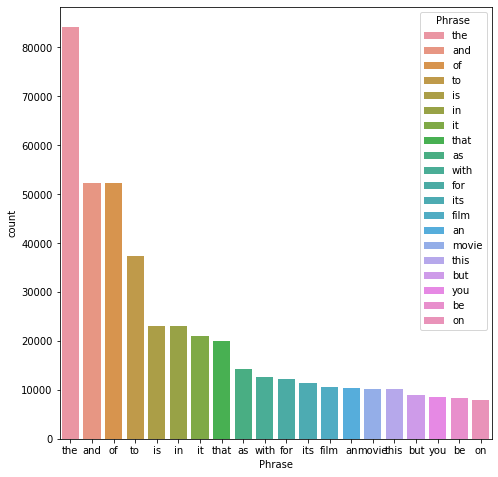

In [26]:
common_words = get_top_n_words(dataset['phrase'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['Phrase' , 'count'])
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
sns.barplot(data=df1, x='Phrase', y='count', ax=ax, hue='Phrase', dodge=False)

The distribution of top unigrams after removing stop words

film 10617
movie 10197
like 5826
story 4138
good 3731
time 3364
just 3270
characters 3045
comedy 2896
does 2780
little 2671
life 2644
make 2496
way 2485
funny 2356
bad 2220
director 2203
new 2094
movies 2021
love 1975


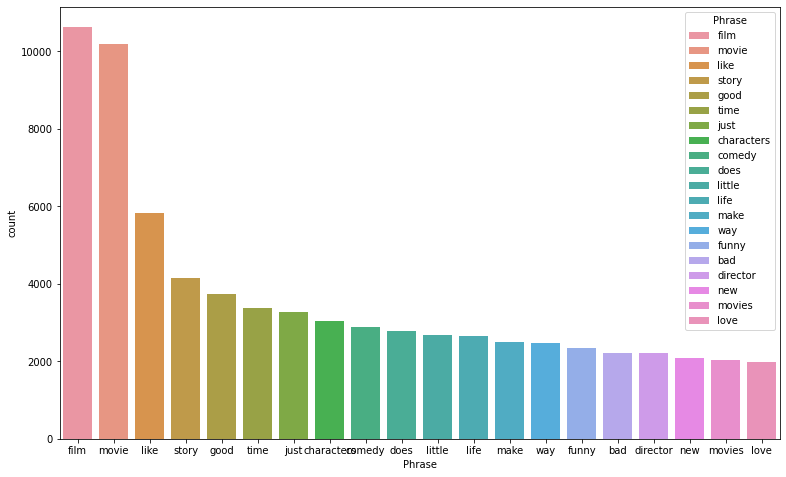

In [29]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dataset['phrase'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Phrase' , 'count'])
fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
sns.barplot(data=df2, x='Phrase', y='count', ax=ax, hue='Phrase', dodge=False)

From the two graphs we can easily compare how the stopwords used in the before vectorizing the corpus is replaced with words that contribute more meaning.